# Policy Gradient

Policy gradient method for reinforcement learning learns the policy directly, not the Q-function. Compared to Q-learning it is more straightforward to use with continuous state and action spaces.

## Log derivative trick

In reinforcement learning we are trying to find a policy that maximizes the sum of rewards over episode.

$$
R = r_1 + r_2 + ... + r_n
$$

$$
\pi^* = argmax_{\pi} E[R]
$$

Expectation here is over environment transitions $P(s_{t+1}|s_t, a_t)$ and actions chosen by the policy $\pi_{\theta}(a_t|s_t)$, where $\theta$ is the parameters (network weights) of the policy. In general case this could be seen as a maximization of expected total reward $R(\tau)$ for trajectory $\tau = <s_0, a_0, r_1, s_1, a_1, ..., r_n, s_n>$, when the only thing we can change is the probability of the trajectory, denoted by $p_{\theta}(\tau)$:

$$
\max E_{\tau \sim p_{\theta}(\tau)}[R(\tau)]
$$

While the probability of trajectory $\tau$ depends both on environment dynamics $P(s_{t+1}|s_t, a_t)$ and policy $\pi_{\theta}(a_t|s_t)$, we only have control over the latter. Therefore we want to change the policy parameters $\theta$ in a way that would maximize the expectation (average value) of $R(\tau)$. We can do this by taking gradient steps with respect to the $\theta$:

$$
\nabla_{\theta} E_{\tau \sim p_{\theta}(\tau)}[R(\tau)]
$$

Computing this gradient is not straightforward, but turns out we can modify the equation so that we can estimate the gradient using Monte-Carlo sampling:

$$
\begin{align}
\nabla_{\theta} E_{\tau \sim p_{\theta}(\tau)}[R(\tau)] &= \nabla_{\theta} \sum_{\tau} p_{\theta}(\tau) R(\tau) & \text{definition of expectation} \\
& = \sum_{\tau} \nabla_{\theta} p_{\theta}(\tau) R(\tau) & \text{swap sum and gradient} \\
& = \sum_{\tau} p_{\theta}(\tau) \frac{\nabla_{\theta} p_{\theta}(\tau)}{p_{\theta}(\tau)} R(\tau) & \text{both multiply and divide by } p_{\theta}(\tau) \\
& = \sum_{\tau} p_{\theta}(\tau) \nabla_{\theta} \log p_{\theta}(\tau) R(\tau) & \text{use the fact that } \nabla_{\theta} \log(x) = \frac{1}{x} \nabla_{\theta} x \\
& = E_{\tau \sim p_{\theta}(\tau)}[\nabla_{\theta} \log p_{\theta}(\tau) R(\tau)] & \text{definition of expectation}
\end{align}
$$

Because the expectation is still over $p_{\theta}(\tau)$, we can sample trajectory $\tau$ as usual, compute its total reward with $R(\tau)$ and this multiplied with $\nabla_{\theta} \log p_{\theta}(\tau)$ is the unbiased estimate of the gradient.

## Policy gradient formula

With little bit more work we can show that $\nabla_{\theta} \log \pi_{\theta}(\tau)$ does not depend on enironment dynamics $P(s_{t+1}|s_t, a_t)$, only on policy $\pi_{\theta}(a_t|s_t)$:

$$
\begin{align}
p_{\theta}(\tau) &= p(s_0)\prod_{t=0}^n\pi_{\theta}(a_t|s_t)P(s_{t+1}|s_t,a_t) & \text{probability of a trajectory}\\
\log p_{\theta}(\tau) &= \log p(s_0) + \sum_{t=0}^n \log p_{\theta}(a_t|s_t) + \log P(s_{t+1}|s_t,a_t) & \text{log probability of a trajectory}\\
\nabla_{\theta} \log p_{\theta}(\tau) &= \sum_{t=0}^n \nabla_{\theta} \log \pi_{\theta}(a_t|s_t) & \text{environment dynamics does not depend on }\theta
\end{align}
$$

Thanks to log-derivative trick we can operate with summation, not with multiplication. In the sum all the derivatives of environment dynamics probabilities are zero, because they do not depend on policy parameters $\theta$. The final form of policy gradient formula is as follows:
$$
\nabla_{\theta} E[R] = E\left[\sum_{t=0}^n \nabla_{\theta} \log \pi_{\theta}(a_t|s_t) R \right]
$$

## Reduction of variance

While the above derivation may be mathematically elegant, the resulting gradient estimator is very noisy. Turns out there are multiple ways to reduce the variance of the gradient.

### Use return instead of total reward

Because the goodness of an action cannot possibly depend on actions and rewards before it, we can safely replace total reward $R$ with return $R_t$:

$$
\nabla_{\theta} E[R] = E\left[\sum_{t=0}^n \nabla_{\theta} \log \pi_{\theta}(a_t|s_t) R_t \right]
$$

### Use constant baseline

If we subtract a constant from return in policy gradient formula, it does not affect the result (because derivative of constant is zero) and it can substantially reduce the variance, therefore reducing the time to convergence. 

$$
\nabla_{\theta} E[R] = E\left[\sum_{t=0}^n \nabla_{\theta} \log \pi_{\theta}(a_t|s_t) (R_t - b) \right]
$$

The quantity $R_t -b$ is sometimes called an **advantage**. Indeed it measures "how much better was the return this time compared to the average".

### Use state value as a baseline

Even better than using constant baseline is to use state value $V(s_t)$ as a baseline ([why we can do this?](https://ai.stackexchange.com/questions/7896/why-is-baseline-conditional-on-state-at-some-timestep-unbiased)):

$$
\nabla_{\theta} E[R] = E\left[\sum_{t=0}^n \nabla_{\theta} \log \pi_{\theta}(a_t|s_t) (R_t - V(s_t)) \right]
$$

Indeed "average return from state $s_t$" is basically the definition of state value $V(s_t)$ and therefore it is the best possible baseline.

## Intuition

While the mathematical derivation of policy gradient might be a bit involved, the intuition behind it is pretty straightforward. First note that without the advantage part, the policy gradient formula is just normal log-likelihood maximization, meaning it increases the probability of chosen actions. Advantages just weight whether the probability is increased or decreased and how much:

* if $R_t - b$ is positive, then current return was better than usual and the probability of the action is *increased*.
* if $R_t - b$ is negative, then current return was better than usual and the probability of the action is instead *decreased*.

For example with discrete action space when using softmax operation to calculate the probabilities, decreasing the probability of one action actually means increasing the probability of other actions. In other words - negative advantages say that explore more, try other actions.

<img src="images/pg.png">

## Implementation

When looking at the policy gradient formulas, it may not be evident how to implement it without digging into the depths of TensorFlow. Actually the implementation can be very simple, with a small modification to supervised learning loss function. Remember that most loss functions used in supervised learning actually try to maximize the log-likelihood of the target value:

* categorical cross-entropy loss function is $L = -\sum_i \log(p_{ik})$. By minimizing the negative log probability, it actually tries to maximize the log probability of the target class $k$ of sample $i$.
* mean squared error loss function is $L = \sum_i (\hat{y}_i-y_i)^2$. By minimizing the mean squared error, it [actually tries to](https://www.jessicayung.com/mse-as-maximum-likelihood/) maximize the log probability of $y_i$ under Gaussian distribution with mean $\hat{y}_i$ and fixed standard deviation.

For the general case we can rewrite those loss functions as 

$$
L = -\sum_i \log p_{\theta}(y_i|x_i)
$$

where $x_i$ is the input to the network, $y_i$ is the target output and $\theta$ represents the parameters (weights) of the network. All we need to do, is to augment this loss function with weights for individual samples: 

$$
L = -\sum_i \log p_{\theta}(y_i|x_i) \alpha_i
$$

Sample weighting is used in supervised learning to fight with class imbalance. It is already implemented in Keras as `sample_weight` parameter to `Model.fit()` method. Note that the gradient of the loss function now looks a lot like policy gradient formula:

$$
\nabla_{\theta} L = -\sum_i \nabla_{\theta} \log p_{\theta}(y_i|x_i) \alpha_i
$$

Because sample weights $\alpha_i$ are constants, they pass through the gradient operation as just multipliers.

Now the only thing left is to replace supervised learning terminology with reinforcement learning terms:
$$
\begin{align}
p_{\theta}(y_i|x_i) &= \pi_{\theta}(a_t|s_t)\\
\alpha_i &= R_t - b\\
i &= t
\end{align}
$$

This gives us the policy gradient loss function, with the only difference of negative sign, because loss functions are usually minimized, not maximized:
$$
L = -\sum_{t=0}^n \log \pi_{\theta}(a_t|s_t) (R_t - b)
$$

## Algorithm

Finally the policy gradient algorithm goes like this:
```
repeat
  collect a trajectory by sampling actions from policy
  calculate returns per time step
  calculate advantages per time step
  train the policy network with 
    states as inputs
    actions as outputs
    advantages as sample weights
until termination
```

# CartPole Example

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
# create the CartPole environment
env = gym.make('CartPole-v0')
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(4,)
Action space: Discrete(2)


In [3]:
# create a model with two hidden layers
x = Input(shape=env.observation_space.shape)
h1 = Dense(64, activation='tanh')(x)
h2 = Dense(64, activation='tanh')(h1)
p = Dense(env.action_space.n, activation='softmax')(h2)

# use RMSProp optimizer and categorical crossentropy loss
model = Model(x, p)
model.compile(optimizer=RMSprop(0.003), loss='sparse_categorical_crossentropy')

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 4,610
Trainable params: 4,610
Non-trainable params: 0
_________________________________________________________________


In [4]:
# calculate returns
def calculate_returns(rewards, dones, discount=0.9):
    returns = []
    for reward, done in zip(reversed(rewards), reversed(dones)):
        if done:
            ret = reward
        else:
            ret = reward + discount * ret
        returns.insert(0, ret)
    return returns

# buffers to keep average returns per timestep
timestep_returns = np.zeros(env.spec.max_episode_steps)
timestep_counts = np.zeros(env.spec.max_episode_steps)

# calculate baselines
def calculate_baselines(returns):
    # use simple timestep-dependent average as baseline
    timestep_returns[:len(returns)] += returns
    timestep_counts[:len(returns)] += 1
    baselines = timestep_returns[:len(returns)] / timestep_counts[:len(returns)]
    return baselines

# calculate advantages
def calculate_advantages(returns, baselines):
    # calculate advantages
    advantages = returns - baselines
    # normalize advantages
    advantages /= np.std(advantages) + 0.000001
    return advantages

In [5]:
# reset statistics
episode_rewards = []
episode_lengths = []

# do 100 episodes
for i in range(100):
    states = []
    actions = []
    rewards = []
    dones = []
    episode_reward = 0
    episode_length = 0

    # collect a trajectory
    state = env.reset()
    done = False
    while not done:
        # predict action probabilities from state
        p = model.predict_on_batch(state[np.newaxis])
        # sample action from probabilities
        action = np.random.choice(env.action_space.n, p=p[0])

        # log state and action
        states.append(state)
        actions.append(action)

        # step environment
        state, reward, done, info = env.step(action)
        #env.render()

        # log reward and done
        rewards.append(reward)
        dones.append(done)

        # sum rewards per episode
        episode_reward += reward
        episode_length += 1

    # record reward statistics
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)

    print("Episode ", i + 1, "Episode reward:", episode_reward, "Episode length:", episode_length)

    # calculate returns
    returns = calculate_returns(rewards, dones)
    
    # calculate baselines
    baselines = calculate_baselines(returns)
    
    # calculate advantages
    advantages = calculate_advantages(returns, baselines)
    
    # train the network, skip training if all advantages are zeros
    if np.any(advantages):
        model.train_on_batch(np.array(states), np.array(actions), sample_weight=advantages)

Episode  1 Episode reward: 25.0 Episode length: 25
Episode  2 Episode reward: 11.0 Episode length: 11
Instructions for updating:
Use tf.cast instead.
Episode  3 Episode reward: 20.0 Episode length: 20
Episode  4 Episode reward: 35.0 Episode length: 35
Episode  5 Episode reward: 33.0 Episode length: 33
Episode  6 Episode reward: 46.0 Episode length: 46
Episode  7 Episode reward: 45.0 Episode length: 45
Episode  8 Episode reward: 60.0 Episode length: 60
Episode  9 Episode reward: 26.0 Episode length: 26
Episode  10 Episode reward: 30.0 Episode length: 30
Episode  11 Episode reward: 45.0 Episode length: 45
Episode  12 Episode reward: 30.0 Episode length: 30
Episode  13 Episode reward: 38.0 Episode length: 38
Episode  14 Episode reward: 19.0 Episode length: 19
Episode  15 Episode reward: 69.0 Episode length: 69
Episode  16 Episode reward: 46.0 Episode length: 46
Episode  17 Episode reward: 41.0 Episode length: 41
Episode  18 Episode reward: 74.0 Episode length: 74
Episode  19 Episode rewar

Text(0.5, 1.0, 'Episode lengths')

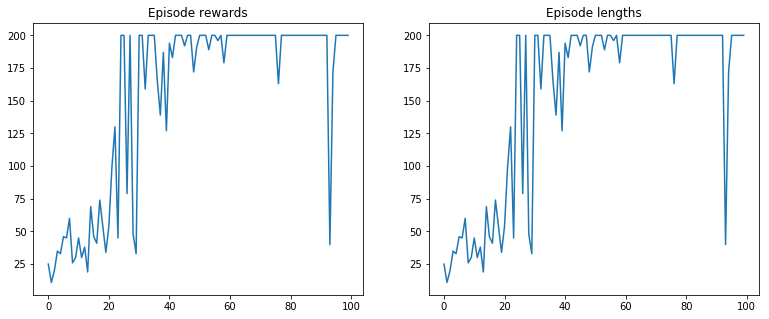

In [6]:
# plot episode rewards and lengths
# because in this environment you get reward 1 for each timestep you are alive, 
# then episode reward matches with episode length
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title("Episode rewards")
plt.subplot(1, 2, 2)
plt.plot(episode_lengths)
plt.title("Episode lengths")

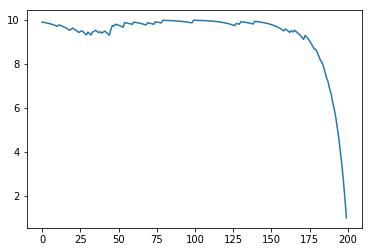

In [7]:
# plot average timestep returns. remember that these are discounted!
plt.plot(timestep_returns / timestep_counts)

In [8]:
# visualize one episode
state = env.reset()
done = False
env.render()
while not done:
    p = model.predict(state[np.newaxis])
    action = np.argmax(p[0])
    
    state, reward, done, info = env.step(action)
    env.render()
env.close()

## Final words

If you have access to environment dynamics function $P(s'|s,a)$ and reward function $R(s, a, s')$ and both are differentiable, you could theoretically optimize $E[R]$ explicitly. In practice there are some instability issues, for details see [these slides](http://rail.eecs.berkeley.edu/deeprlcourse/static/slides/lec-13.pdf) or [this paper](https://arxiv.org/abs/1510.09142). Still, it is a good idea to make use of environment model, whenever it is available (or learnable).